In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d

In [34]:
# File paths for each year's CSV data
file_paths = {

    '2023': './Pricing_Data/PUB_PriceHOEPPredispOR_2023_v393.csv'
}


# Combine all years of data into a single DataFrame
all_data = pd.DataFrame()
for file_path in file_paths.values():
    yearly_data = pd.read_csv(file_path, skiprows=2)
    yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
    yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
    yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
    all_data = pd.concat([all_data, yearly_data])

# Clean the data and reset index
all_data.reset_index(drop=True, inplace=True)
all_data.dropna(subset=['HOEP'], inplace=True)



# Load price data, ensure all_data is correctly defined
hourly_prices = all_data['HOEP'].values

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Initial conditions
initial_capacity = 4  # MWh

# Dictionary to hold profits for each cycle type
profits = {}

def simulate_daily_cycling(capacity_func, prices, initial_capacity):
    daily_profit = 0
    cycle_count = 0
    days = len(prices) // 24  # Assuming prices are hourly and we have complete days

    for day in range(days):
        daily_prices = prices[day*24:(day+1)*24]
        if len(daily_prices) < 24:
            continue  # Skip incomplete days

        # Determine the lowest and highest price hours
        min_price_hour = np.argmin(daily_prices)
        max_price_hour = np.argmax(daily_prices)

        # Current capacity based on cycles done so far
        current_capacity = capacity_func(cycle_count) * initial_capacity
        cycle_count += 1  # Each day counts as one cycle

        # Calculate profit from the chosen strategy
        buy_price = daily_prices[min_price_hour]
        sell_price = daily_prices[max_price_hour]
        # Assume the battery can fully charge and discharge within these hours
        daily_profit += (sell_price - buy_price) * current_capacity

    return daily_profit

# Run the simulation for each degradation model and plot results
for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100  # Convert percentages to fraction of initial capacity

    # Create a linear interpolation function for battery capacity
    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")

    # Extract model basename
    basename = os.path.basename(file_path).replace('.csv', '')
    
    # Simulate and store the result
    profits[basename] = simulate_daily_cycling(capacity_func, hourly_prices, initial_capacity)

# Display results
for cycle_type, profit in profits.items():
    print(f"{cycle_type}: ${profit:.2f}")


100to25: $63498.54
100to40: $64046.52
100to50: $64298.88
75to25: $64570.20
75to45: $65070.29
75to65: $65524.01
85to25: $64397.53


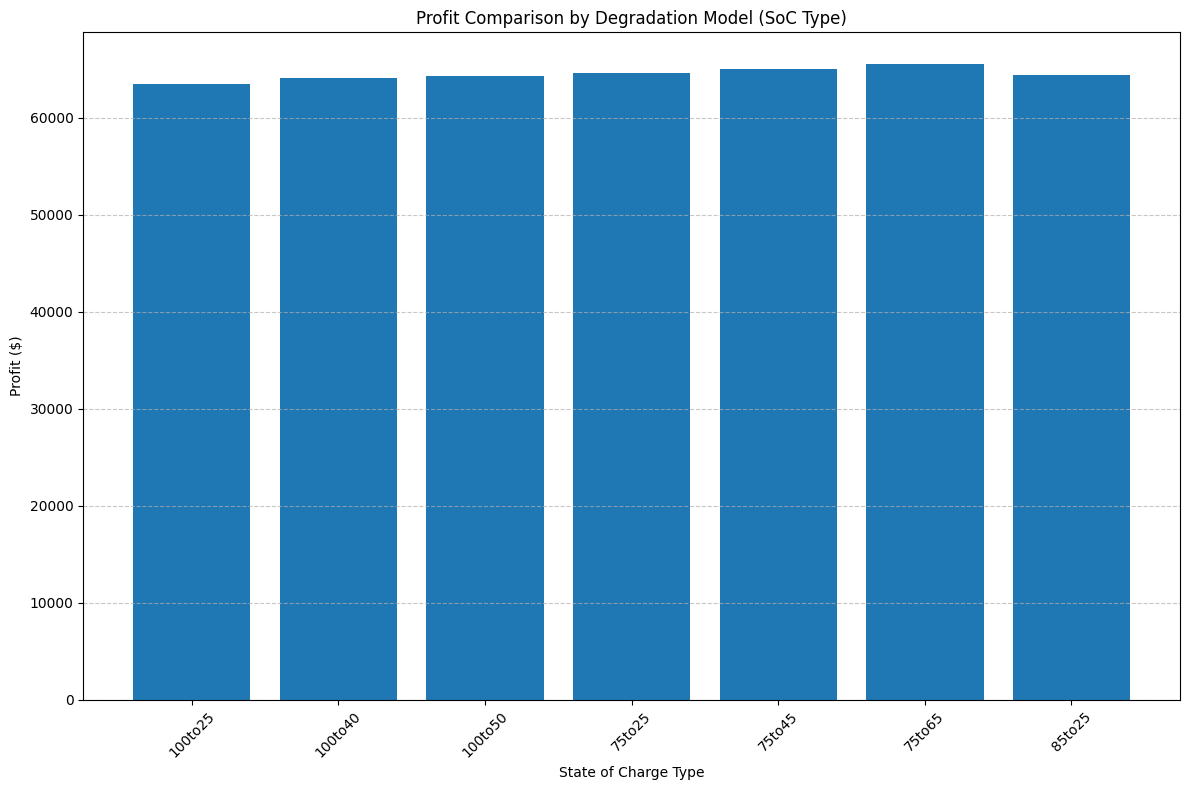

In [35]:
# Extract SoC types and corresponding profits for plotting
soc_types = list(profits.keys())
profit_values = list(profits.values())

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(soc_types, profit_values)

# Add titles and labels
plt.title('Profit Comparison by Degradation Model (SoC Type)')
plt.xlabel('State of Charge Type')
plt.ylabel('Profit ($)')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

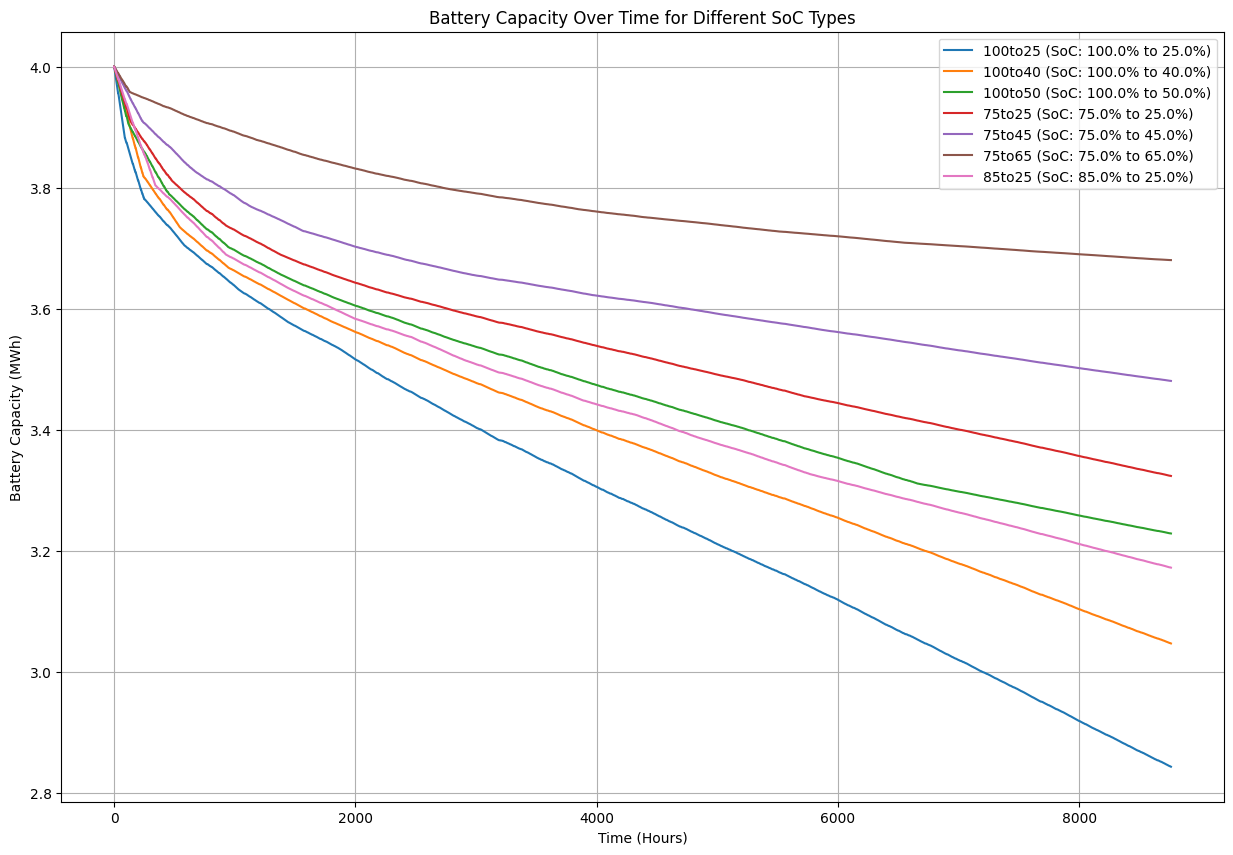

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

# Load the price data
hourly_prices = all_data['HOEP'].values  # Make sure to define 'all_data' with hourly price data

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Initial conditions
initial_capacity = 4  # MWh
charge_rate = 1  # MW/h
discharge_rate = 1  # MW/h

# Function to simulate energy arbitrage and track capacity
def simulate_and_track_capacity(capacity_func, prices, initial_capacity, charge_rate, discharge_rate, min_charge_level, max_charge_level):
    energy_stored = 0
    cycle_count = 0
    capacities = [initial_capacity]  # Track capacity over time

    for i in range(1, len(prices)):
        current_capacity = capacity_func(cycle_count) * initial_capacity
        min_allowed_energy = current_capacity * min_charge_level
        max_allowed_energy = current_capacity * max_charge_level
        
        predicted_next_price = prices[i]
        current_price = prices[i-1]

        if current_price < predicted_next_price and energy_stored < max_allowed_energy:
            energy_to_charge = min(charge_rate, max_allowed_energy - energy_stored)
            energy_stored += energy_to_charge
            cycle_count += 1
        elif current_price > predicted_next_price and energy_stored > min_allowed_energy:
            energy_to_sell = min(discharge_rate, energy_stored - min_allowed_energy)
            energy_stored -= energy_to_sell
            cycle_count += 1

        capacities.append(current_capacity)

    return capacities

# Run the simulation for each degradation model and plot the results
plt.figure(figsize=(15, 10))

for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100

    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")
    basename = os.path.basename(file_path).replace('.csv', '')
    max_charge_level, min_charge_level = map(int, basename.split('to'))
    min_charge_level /= 100
    max_charge_level /= 100

    tracked_capacities = simulate_and_track_capacity(capacity_func, hourly_prices, initial_capacity, charge_rate, discharge_rate, min_charge_level, max_charge_level)
    plt.plot(tracked_capacities, label=f'{basename} (SoC: {max_charge_level*100}% to {min_charge_level*100}%)')

plt.title('Battery Capacity Over Time for Different SoC Types')
plt.xlabel('Time (Hours)')
plt.ylabel('Battery Capacity (MWh)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

# Constants
final_percentage = 0.40
max_cycles = 15000  # Set maximum cycle count

# Load a single year's price data to be repeated
file_path = './Pricing_Data/PUB_PriceHOEPPredispOR_2023_v393.csv'
yearly_data = pd.read_csv(file_path, skiprows=2)
yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
hourly_prices = yearly_data['HOEP'].values

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Initial conditions
initial_capacity = 4  # MWh

# Function to simulate energy arbitrage and track capacity
def simulate_daily_cycling(capacity_func, prices, initial_capacity, target_capacity, max_cycles):
    daily_profit = 0
    cycle_count = 0
    days = len(prices) // 24  # Assuming prices are hourly and we have complete days
    current_capacity = initial_capacity

    while current_capacity > target_capacity and cycle_count < max_cycles:
        for day in range(days):
            if current_capacity <= target_capacity or cycle_count >= max_cycles:
                break  # Stop the simulation if capacity drops to the target or max cycles reached
            daily_prices = prices[day*24:(day+1)*24]
            if len(daily_prices) < 24:
                continue  # Skip incomplete days

            min_price_hour = np.argmin(daily_prices)
            max_price_hour = np.argmax(daily_prices)

            current_capacity = capacity_func(cycle_count) * initial_capacity
            buy_price = daily_prices[min_price_hour]
            sell_price = daily_prices[max_price_hour]

            daily_profit += (sell_price - buy_price) * current_capacity
            cycle_count += 1  # Increment cycle count for each full day

    return daily_profit, cycle_count

# Simulate and compare results for each degradation model
profits = {}
cycles_used = {}

for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100  # Convert percentages to fraction of initial capacity

    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")
    basename = os.path.basename(file_path).replace('.csv', '')
    target_capacity = final_percentage * initial_capacity

    profit, cycles = simulate_daily_cycling(capacity_func, hourly_prices, initial_capacity, target_capacity, max_cycles)
    profits[basename] = profit
    cycles_used[basename] = cycles

# Display results
for cycle_type, profit in profits.items():
    print(f"{cycle_type} Profit: ${profit:.2f}")
    print(f"{cycle_type} Cycles Used: {cycles_used[cycle_type]}")


100to25 Profit: $1943909.91
100to25 Cycles Used: 15000
100to40 Profit: $2069735.10
100to40 Cycles Used: 15000
100to50 Profit: $2210080.55
100to50 Cycles Used: 15000
75to25 Profit: $2258404.16
75to25 Cycles Used: 15000
75to45 Profit: $2371926.60
75to45 Cycles Used: 15000
75to65 Profit: $2508862.75
75to65 Cycles Used: 15000
85to25 Profit: $2170104.38
85to25 Cycles Used: 15000


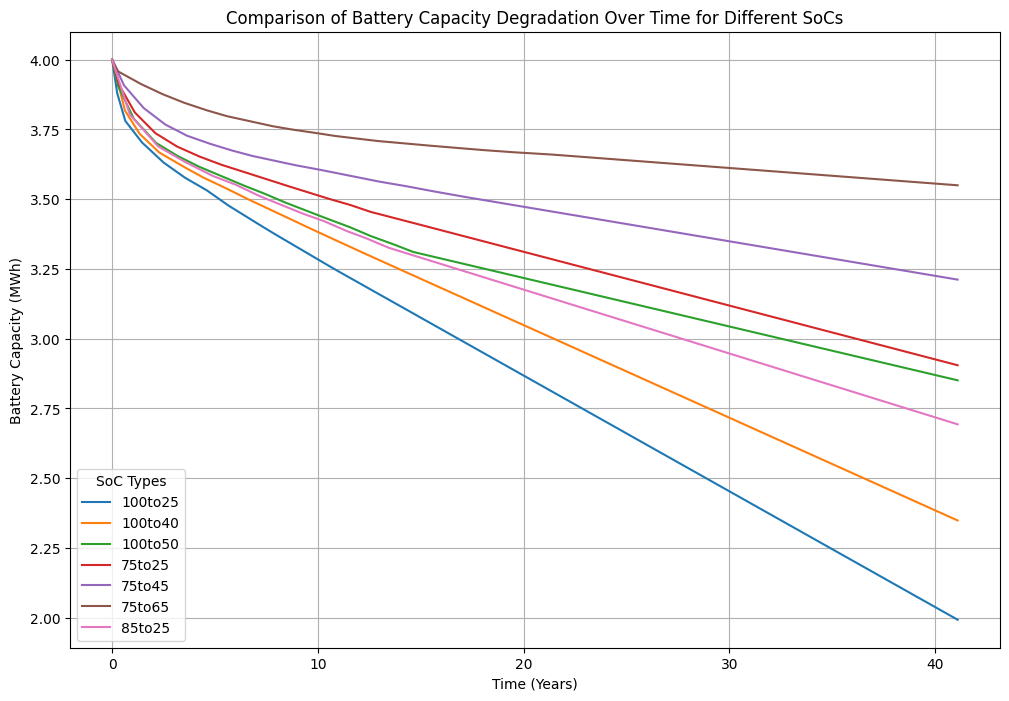

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from scipy.interpolate import interp1d

# Load price data and prepare
file_path = './Pricing_Data/PUB_PriceHOEPPredispOR_2023_v393.csv'
yearly_data = pd.read_csv(file_path, skiprows=2)
yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
hourly_prices = yearly_data['HOEP'].values

# Constants
hours_per_year = 24 * 365  # Total hours in a year
initial_capacity = 4  # MWh

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Prepare the figure for plotting
plt.figure(figsize=(12, 8))

# Process each file and plot on the same figure
for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100

    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")
    basename = os.path.basename(file_path).replace('.csv', '')
    
    # Assuming 'cycles_used' contains the number of cycles until capacity reaches 25%
    cycles = cycles_used[basename]  # Ensure this data is available from previous simulations

    # Calculate capacity over time
    hours = np.arange(0, cycles * 24, 24)
    capacities = capacity_func(hours / 24) * initial_capacity
    years = hours / hours_per_year

    # Plot each SoC's capacity curve
    plt.plot(years, capacities, label=f'{basename}')

# Finalize the plot
plt.title('Comparison of Battery Capacity Degradation Over Time for Different SoCs')
plt.xlabel('Time (Years)')
plt.ylabel('Battery Capacity (MWh)')
plt.legend(title="SoC Types")
plt.grid(True)
plt.show()


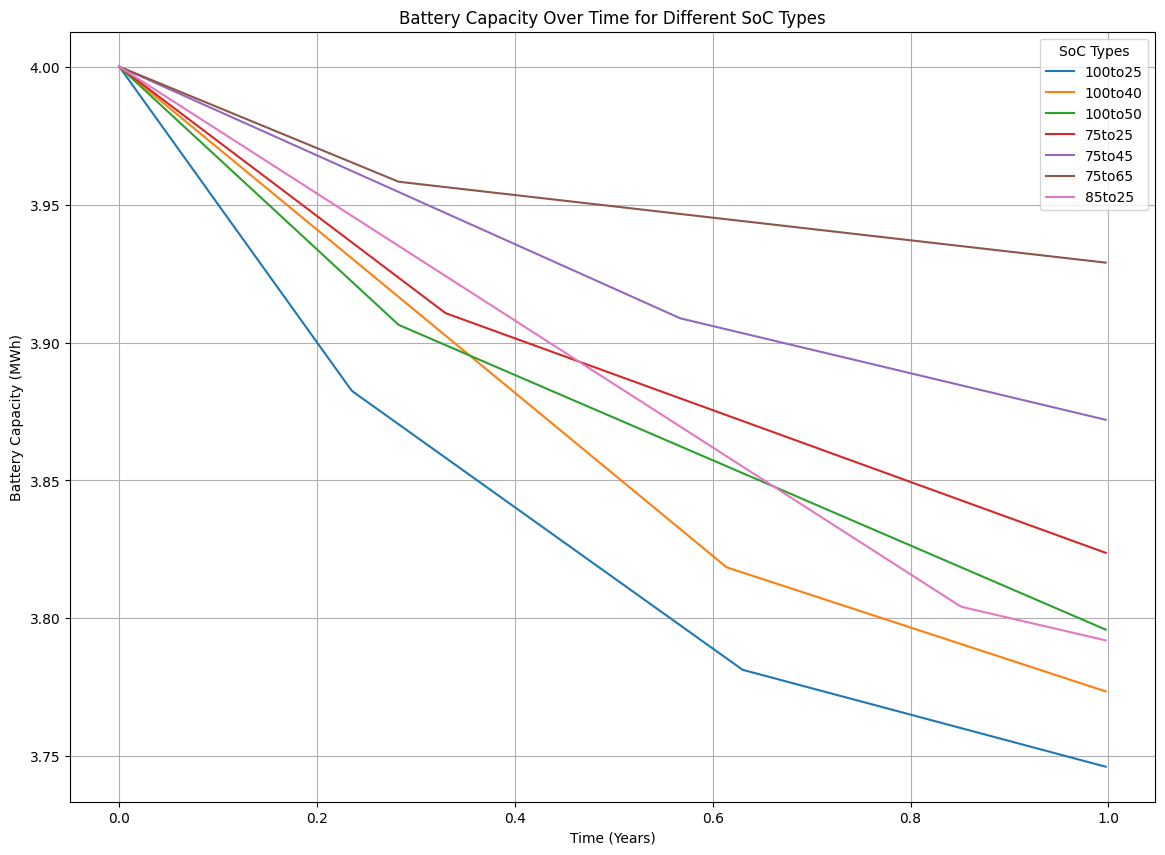

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

def simulate_daily_cycling_with_capacity_tracking(capacity_func, prices, initial_capacity, days_per_year=365):
    cycle_count = 0
    daily_capacities = []  # Store daily capacities here

    # Convert prices to a list of daily prices assuming prices are given hourly
    daily_prices = [prices[i:i+24] for i in range(0, len(prices), 24)]

    for day_prices in daily_prices:
        if len(day_prices) < 24:
            continue  # Ensure full days only

        # Determine the lowest and highest price hours
        min_price_hour = np.argmin(day_prices)
        max_price_hour = np.argmax(day_prices)

        # Calculate the current battery capacity from the degradation model
        current_capacity = capacity_func(cycle_count) * initial_capacity

        # Store the daily capacity
        daily_capacities.append(current_capacity)

        # Increment the cycle count
        cycle_count += 1

        # Check if the battery should stop cycling after reaching 25% of original capacity
        if current_capacity <= 0.25 * initial_capacity:
            break

    return daily_capacities

# Load and prepare data
hourly_prices = all_data['HOEP'].values
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Track capacity for each degradation model
capacities_over_time = {}

for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    cycle_numbers = data.iloc[:, 0].values
    capacities = data.iloc[:, 1].values / 100
    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")
    
    basename = os.path.basename(file_path).replace('.csv', '')
    capacities_over_time[basename] = simulate_daily_cycling_with_capacity_tracking(capacity_func, hourly_prices, initial_capacity=4)

# Plotting capacity over time
plt.figure(figsize=(14, 10))
for soc_type, capacities in capacities_over_time.items():
    years = np.arange(len(capacities)) / 365  # Convert days to years
    plt.plot(years, capacities, label=soc_type)

plt.title('Battery Capacity Over Time for Different SoC Types')
plt.xlabel('Time (Years)')
plt.ylabel('Battery Capacity (MWh)')
plt.legend(title="SoC Types")
plt.grid(True)
plt.show()


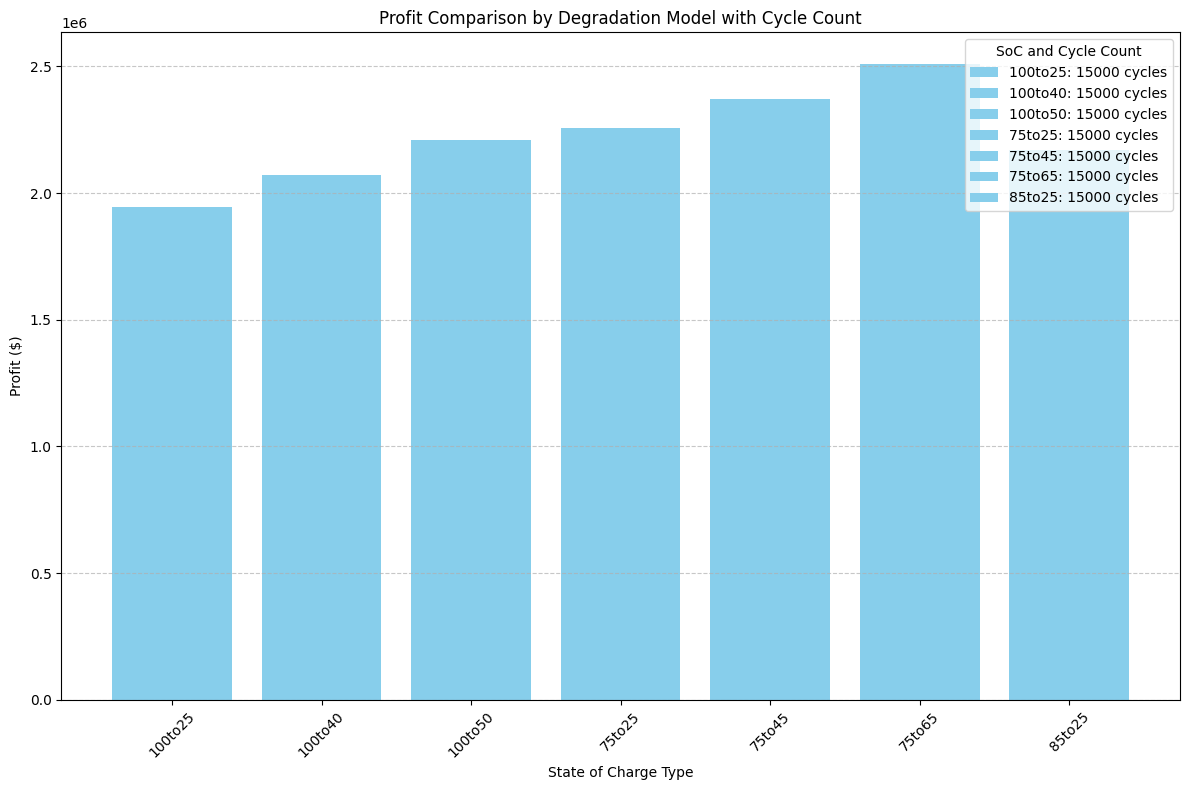

In [40]:
import matplotlib.pyplot as plt

# Assuming 'profits' and 'cycles_used' dictionaries are filled as per the previous simulation code

# Extract SoC types, corresponding profits, and cycles used for plotting
soc_types = list(profits.keys())
profit_values = list(profits.values())
cycles_for_soc = [cycles_used[soc] for soc in soc_types]

# Create a bar chart for profits
plt.figure(figsize=(12, 8))
bars = plt.bar(soc_types, profit_values, color='skyblue')

# Adding a legend with the number of cycles used
cycle_legends = [f"{soc}: {cycles} cycles" for soc, cycles in zip(soc_types, cycles_for_soc)]
plt.legend(bars, cycle_legends, title="SoC and Cycle Count")

# Add titles and labels
plt.title('Profit Comparison by Degradation Model with Cycle Count')
plt.xlabel('State of Charge Type')
plt.ylabel('Profit ($)')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()
